# Experiment number 1 (cifar10):

## Cutting between 50% of the samples according to the metrics and comparing to random cutting and a normal model without cutting
## the metrics: EL2N, forget, flip, pred sum, std and km

### get dataset and metrics and print correlation


In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import Tensor

from train import ModelManager, DIR_ROOT_SAVE, DIR_ROOT_LOG
from utils import get_loader, get_cifar10

# globals
NUM_CLASSES = 10
BATCH_SIZE = 25
NUM_TRAIN = 50000
NUM_TEST = 10000
EPOCHS = 60

NOTEBOOK_NAME = 'prune_50p_cifar10'
PATH_EL2N = os.path.join(DIR_ROOT_SAVE, 'el2n_resnet18_cifar10', 'general.pt')
PATH_FORGET = os.path.join(DIR_ROOT_SAVE, 'flip_cifar10', 'model', 'other.pt')
PATH_LOG = os.path.join(DIR_ROOT_LOG, NOTEBOOK_NAME, 'test_acc.pt')

print('train on:', ModelManager.DEVICE)

train_idx = np.arange(NUM_TRAIN, dtype=int)
test_idx = np.arange(NUM_TEST, dtype=int)
dataset_train, dataset_test, dataset_train_for_test, dataset_train_raw = get_cifar10()
loader_test = get_loader(dataset_test, test_idx, BATCH_SIZE, shuffle=False)
loader_train_ordered = get_loader(dataset_train_for_test, train_idx, BATCH_SIZE, shuffle=False)
Y_train = Tensor(dataset_train.targets)[train_idx].type(torch.int64)
Y_test = Tensor(dataset_test.targets)[test_idx].type(torch.int64)

# get prune scores
data = torch.load(PATH_EL2N)

ensemble_softmax = data['ensemble_softmax']
ensemble_pred = data['ensemble_pred']
ensemble_pred_sum = data['ensemble_pred_sum']
ensemble_std = data['ensemble_std']
el2n_scores = data['el2n_scores']
change_counter = torch.load(PATH_FORGET)['change_counter']
true_forget = torch.load(PATH_FORGET)['true_forget']
km5 = np.load(os.path.join(DIR_ROOT_SAVE, 'swav_cifar10_512', 'km_dist_5.npy'))
km10 = np.load(os.path.join(DIR_ROOT_SAVE, 'swav_cifar10_512', 'km_dist_10.npy'))
km = np.load(os.path.join(DIR_ROOT_SAVE, 'swav_cifar10_512', 'km_dist.npy'))
km100 = np.load(os.path.join(DIR_ROOT_SAVE, 'swav_cifar10_512', 'km_dist_100.npy'))
km200 = np.load(os.path.join(DIR_ROOT_SAVE, 'swav_cifar10_512', 'km_dist_200.npy'))

idx_sorted_el2n = el2n_scores.sort()[1].numpy()
idx_sorted_forgetting = change_counter.sort()[1].numpy()
idx_sorted_std = ensemble_std.sum(dim=1).sort()[1].numpy()
idx_sorted_pred_sum = ensemble_pred_sum.sort()[1].numpy()[::-1]
idx_true_forget = true_forget.sort()[1].numpy()
idx_random_prune = np.random.choice(np.arange(NUM_TRAIN), NUM_TRAIN, replace=False)
idx_sorted_km5 = np.argsort(km5)
idx_sorted_km10 = np.argsort(km10)
idx_sorted_km = np.argsort(km)
idx_sorted_km100 = np.argsort(km100)
idx_sorted_km200 = np.argsort(km200)

idx_sorted = {'random': idx_random_prune, 'el2n': idx_sorted_el2n, 'std': idx_sorted_std,
              'pred_sum': idx_sorted_pred_sum, 'flip': idx_sorted_forgetting, 'forget': idx_true_forget,
              'km5': idx_sorted_km5, 'km10': idx_sorted_km10, 'km': idx_sorted_km, 'km100': idx_sorted_km100,
              'km200': idx_sorted_km200}

data = pd.DataFrame({
    'EL2N': el2n_scores.numpy(),
    'Std': ensemble_std.sum(dim=1).numpy(),
    'True p sum': ensemble_pred_sum.numpy(),  # number of models that right on each example
    'flip': change_counter.numpy(),
    'forget': true_forget.numpy(),
    'km5': km5,
    'km10': km10,
    'km': km,
    'km100': km100,
    'km200': km200,
})
data.corr()

train on: cuda
Files already downloaded and verified
Files already downloaded and verified


,EL2N,Std,True p sum,flip,forget,km5,km10,km,km100,km200
EL2N,1.000000,0.780107,-0.944299,0.658627,0.399751,0.328029,0.471619,0.529046,0.508376,0.517344
Std,0.780107,1.000000,-0.660269,0.586532,0.377763,0.309604,0.455924,0.496631,0.472651,0.474010
True p sum,-0.944299,-0.660269,1.000000,-0.627331,-0.350162,-0.284363,-0.397917,-0.460980,-0.447110,-0.455366
flip,0.658627,0.586532,-0.627331,1.000000,0.770378,0.259929,0.351784,0.394874,0.385965,0.396651
forget,0.399751,0.377763,-0.350162,0.770378,1.000000,0.161169,0.223201,0.253914,0.250495,0.258186
km5,0.328029,0.309604,-0.284363,0.259929,0.161169,1.000000,0.580492,0.417282,0.387067,0.388392
km10,0.471619,0.455924,-0.397917,0.351784,0.223201,0.580492,1.000000,0.557792,0.502318,0.488052
km,0.529046,0.496631,-0.460980,0.394874,0.253914,0.417282,0.557792,1.000000,0.803341,0.733060
km100,0.508376,0.472651,-0.447110,0.385965,0.250495,0.387067,0.502318,0.803341,1.000000,0.818507
km200,0.517344,0.474010,-0.455366,0.396651,0.258186,0.388392,0.488052,0.733060,0.818507,1.000000


In [3]:
# change to false in the first time you run this code
# after the first time the model will saved in models_data folder
already_trained = True

regular_model = ModelManager(NUM_CLASSES, 'no_prune', dir_=NOTEBOOK_NAME, load=already_trained)
if not  already_trained:
    loader_train = get_loader(dataset_train, train_idx, BATCH_SIZE, True)
    regular_model.train(loader_train, loader_test, loader_test, EPOCHS)

num_train = int(NUM_TRAIN * (50. / 100.))
models = [regular_model]

print()
for name, idx in idx_sorted.items():
    print(f'====     train model with 50% prune according to {name} most hard     ======')
    if not already_trained:
        loader_train = get_loader(dataset_train, idx[-num_train:], BATCH_SIZE, shuffle=True)
        model_manager = ModelManager(NUM_CLASSES, f'{NOTEBOOK_NAME}_{name}', dir_=NOTEBOOK_NAME, load=False)
        model_manager.train(loader_train, loader_test, loader_test, EPOCHS)
    else:
        model_manager = ModelManager(NUM_CLASSES, f'{NOTEBOOK_NAME}_{name}', dir_=NOTEBOOK_NAME, load=True)
    models.append(model_manager)
    print()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

In [4]:
x1=models[7]
x2=models[8]
x3=models[9]
models[7]=x3
models[8]=x1
models[9]=x2
[model.name for model in models]

['no_prune',
 'prune_50p_cifar10_random',
 'prune_50p_cifar10_el2n',
 'prune_50p_cifar10_std',
 'prune_50p_cifar10_pred_sum',
 'prune_50p_cifar10_flip',
 'prune_50p_cifar10_forget',
 'prune_50p_cifar10_km',
 'prune_50p_cifar10_km5',
 'prune_50p_cifar10_km10',
 'prune_50p_cifar10_km100',
 'prune_50p_cifar10_km200']

### compare the results according to metrics


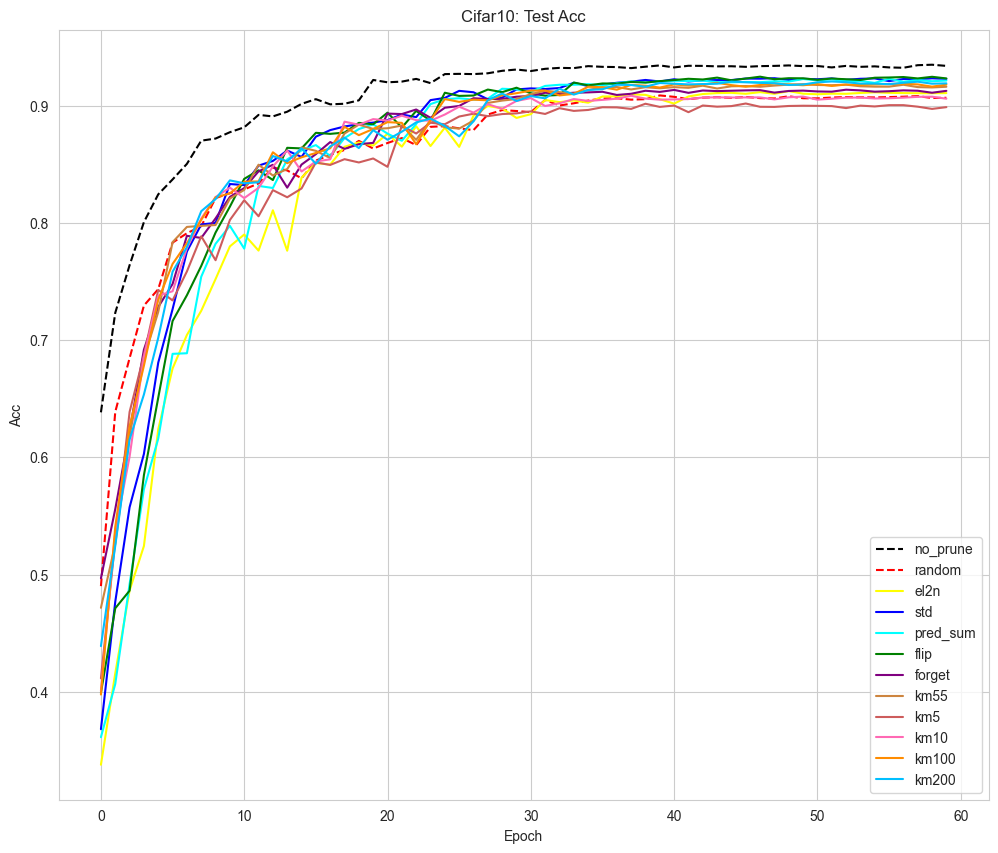

In [5]:
colors = ('black', 'red', 'yellow', 'blue', 'cyan', 'green', 'purple', 'peru','indianred',   'hotpink','darkorange','deepskyblue')
#          no       rand    el2n     std     sum     flip      forget   km      km5            km10             km100        km200
markers = ('dashed', 'solid')
save = {}
epochs_idx = np.arange(EPOCHS)

plt.figure(figsize=(12, 10))
for i, model in enumerate(models):
    name=model.name
    if name!='no_prune':
        name=name.split(NOTEBOOK_NAME)[-1][1:]
    # if 'km' in name or name in ['no_prune','random']:
    if name == 'km':
        name='km55'
    model_valid_acc = np.array(model.data['valid']['acc'])
    plt.plot(epochs_idx, model_valid_acc,
                 label=name,
                 c=colors[i], linestyle=markers[0] if i < 2 else markers[1])
        # save[model.name.split(NOTEBOOK_NAME)[-1][1:] if i != 0 else model.name] = model_valid_acc
plt.legend(loc='lower right')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Cifar10: Test Acc')
plt.show()

In [5]:
save.keys()

dict_keys(['no_prune', 'random', 'el2n', 'std', 'pred_sum', 'flip', 'forget', 'km', 'km5', 'km10', 'km100', 'km200'])

In [6]:
import pickle

with open(os.path.join(DIR_ROOT_SAVE, 'cifar10_50_graph'), 'wb') as f:
    pickle.dump(save, f)